In [ ]:
library(tidyverse)
library(midasr)
library(imputeTS)

In [2]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [ ]:
# full data read
metadata <- read_csv("../data/meta_data.csv")
data <- read_csv("../data/data_tf.csv") %>%
  arrange(date)

target_variable <- "gdpc1"

# which lags to assess
lags <- -2:2

# dates for 3 testing periods
train_start_date <- "1947-01-01"
train_end_date <- "2004-12-01"
test_start_date <- "2005-03-01"
test_end_date <- "2010-12-01"

# train and test datasets
train <- data %>%
    filter(date >= train_start_date, date <= train_end_date) %>%
    # the nowcastDFM library only works with dataframe, may get errors in estimation if you use tibbles
    data.frame()
test <- data %>%
    filter(date >= train_start_date, date <= test_end_date) %>% # let test set data begin from training begin, data lag/time series for test sets can go back into the training data
    data.frame()

# replace any infinites with NA
for (col in colnames(train)) {
    if (sum(is.infinite(train[,col])) > 0) {
      train[is.infinite(train[,col]), col] <- NA 
    }
}

for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

# replace any missings with the mean
train <- na_mean(train)
test <- na_mean(test)

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
tail(data)

date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-08-01,0.003285871,NA,0.002743650,-0.03703704,0.007042254,-0.001631945,-0.001061726,0.001017724,0.003134983,0.003824009,0.05582822,NA,NA
2021-09-01,0.002569910,0.005709481,0.004124361,-0.09615385,-0.014621742,-0.009759164,-0.016184669,0.002430747,0.002405292,0.003465474,-0.07844277,0.02311136,0.01429745
2021-10-01,0.004382672,NA,0.009433205,-0.02127660,0.001290323,0.012332928,-0.001649621,0.005992493,0.004427284,0.006487107,0.04224464,NA,NA
2021-11-01,0.001676734,NA,0.007791157,-0.08695652,0.081185567,0.007374793,-0.001950417,0.005346208,0.004803122,0.006266496,0.03871748,NA,NA
2021-12-01,0.001337797,0.016790944,0.004704532,-0.07142857,0.014302741,-0.001023560,-0.002285343,0.005501393,0.004981080,0.004475995,0.09784508,NA,NA
2022-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# Training the model

In [5]:
# estimating MIDAS models
y <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"),  target_variable]
models <- list()

# for MIDAS, a separate model is trained for each explanatory variable
for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable) {
        if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
            x <- train[substr(train$date, 6, 7) %in% c("03", "06", "09", "12"), col]
            models[[col]] <- midas_r(y ~ mls(x, 0:1, 1, nealmon), start=list(x=c(1, -0.5)))
        } else { # monthly variables, the mls() function handles lagging and flattening the data
            x <- train[,col]
            models[[col]] <- midas_r(y ~ mls(x, 0:3, 3, nealmon), start=list(x=c(1, -0.5)))
        } 
    }
}

# some variables have more predictive power than others, a straight average weighting would give too much weight to those unhelpful variables
# RMSE for weighting based on fit on the training set gives much better results
weight <- list()
for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable) {
        actual <- y[2:length(y)]
        fitted <- models[[col]]$fitted.values
        weight[[col]] <- (fitted - actual)**2 %>% mean() %>% sqrt()
    }
}
# discount the least predictive variable
adj <- abs(unlist(weight) - max(unlist(weight)))
weight <- (adj / sum(adj))

# Testing the model on artificial data vintages

In [6]:
# dates in the test set
dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by="month") %>% 
      .[(substr(., 6, 7) %in% c("03", "06", "09", "12"))]

In [7]:
# dataframe for predictions
pred_dict <- data.frame(date = dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}
# looping through test dates
for (date in as.character(dates)) {
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, test, date, lag) %>% 
      data.frame
    # make sure actual value not in there
    lagged_data[lagged_data$date == date, target_variable] <- NA
    lagged_data <- na_mean(lagged_data) # fill missing with mean to get estimate
      
    y <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"),  target_variable]
    preds <- list()
      
    # loop through all the individual models to get predictions, later will weighted average them
    for (col in colnames(train)[2:ncol(train)]) {
        if (col != target_variable) {
          if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
            x <- lagged_data[substr(lagged_data$date, 6, 7) %in% c("03", "06", "09", "12"), col]
            preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
            preds[[col]] <- preds[[col]][length(preds[[col]])]
          } else { # monthly variables
            x <- lagged_data[,col]
            preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
            preds[[col]] <- preds[[col]][length(preds[[col]])]
          } 
        }
    }
    # averaged predictions
    pred_dict[pred_dict$date == date, as.character(lag)] <- weighted.mean(unlist(preds), weight)
  }
}

# Assess and visualize model performance

In [8]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>%
    select(!!target_variable) %>%
    pull()

In [9]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage,RMSE
<dbl>,<dbl>
-2,0.0078
-1,0.0070
0,0.0064
1,0.0057
2,0.0038


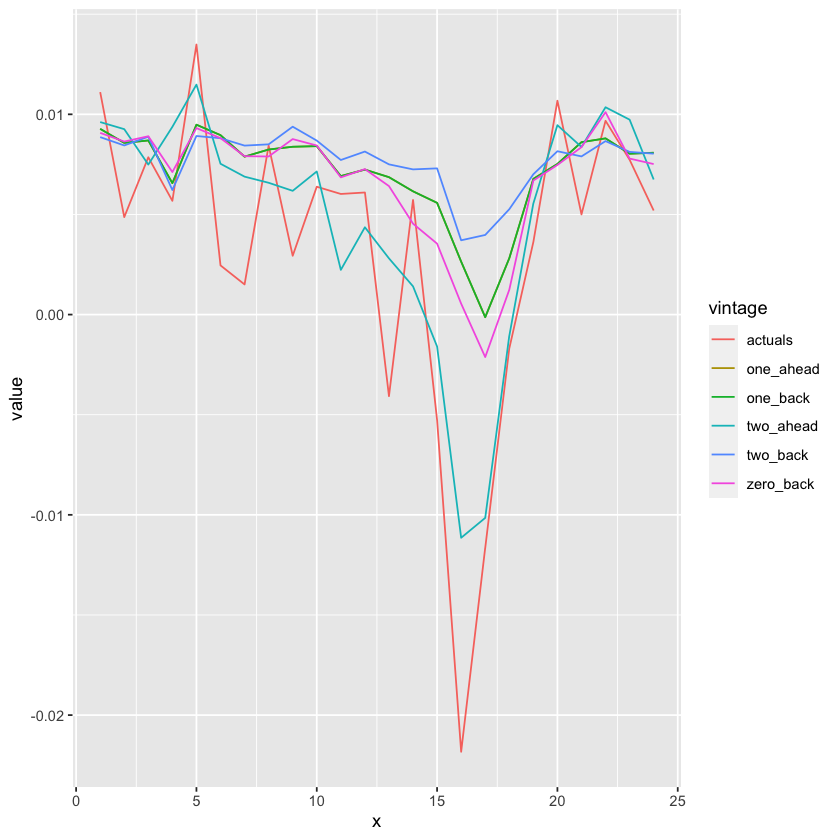

In [10]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [11]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test

# the date we want predicted must be in the date, if it's not there it must be added
desired_date <- "2011-03-01"
months_to_add <- seq(max(new_data$date), as.Date("2011-03-01"), by="month") %>% as.character()

for (value in months_to_add[2:length(months_to_add)]) {
    new_data[nrow(new_data) + 1, "date"] <- value
}

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data %>% tail()

# fill missings
new_data <- new_data %>% na_mean()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
766,2010-10-01,0.0020558927,0.008120786,0.003481846,-0.01052632,-0.085858586,-0.0022996991,8.368621e-05,0.0005367348,0.0015188932,0.003182719,-0.008880995,0.007147295,0.008156394
767,2010-11-01,0.0009569378,0.008120786,0.002533842,0.04255319,0.003683241,0.0004530182,8.451600e-04,0.0014380381,0.0012999340,0.001997191,0.003584229,0.007147295,0.008156394
768,2010-12-01,0.0005506692,0.005195952,0.004016576,-0.05102041,-0.011009174,0.0096567785,5.819155e-03,0.0008732877,0.0002060708,0.002263125,0.128571429,0.001172041,0.002460521
769,2011-01-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
770,2011-02-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
771,2011-03-01,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [12]:
# loop through all the individual models to get predictions, later will weighted average them
for (col in colnames(train)[2:ncol(train)]) {
    if (col != target_variable) {
      if (col %in% c("ulcnfb", "a261rx1q020sbea")) { # quarterly variables
        x <- new_data[substr(new_data$date, 6, 7) %in% c("03", "06", "09", "12"), col]
        preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
        # the `forecast` function from midasr produces predictions for all periods in the data
        # we're interested in the last one, for 2011-03-01
        preds[[col]] <- preds[[col]][length(preds[[col]])]
      } else { # monthly variables
        x <- new_data[,col]
        preds[[col]] <- forecast(models[[col]], newdata=list(x=x))$mean
        preds[[col]] <- preds[[col]][length(preds[[col]])]
      } 
    }
}
# averaged predictions
weighted.mean(unlist(preds), weight)

[1] 0.009248511